# **Stock Price Forecast**

This notebook leverages the power of TensorFlow to build and train a deep learning model, specifically using Long Short-Term Memory (LSTM) networks, aimed at predicting future stock prices based on historical data. The objective is to provide a comprehensive tool for financial analysts and enthusiasts to forecast stock market trends, allowing them to make more informed investment decisions.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-08-21 21:34:57.952373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


***

## **1. Data Collection**

In [2]:
# Set timeline to 1 year ago from today
end_date = datetime.now()
start_date = datetime(end_date.year - 1, end_date.month, end_date.day)

# Define preferred list of stocks
stocks_list = ["AMZN", "GOOG", "MSFT", "TSLA"]

# Download stock data
stocks_data = yf.download(stocks_list, start=start_date, end=end_date)

# Display first 5 rows of datset
stocks_data.head()

[*********************100%%**********************]  4 of 4 completed


Price        Adj Close                                           Close  \
Ticker            AMZN        GOOG        MSFT        TSLA        AMZN   
Date                                                                     
2023-08-21  134.679993  128.783447  319.481934  231.279999  134.679993   
2023-08-22  134.250000  129.542587  320.057617  233.190002  134.250000   
2023-08-23  135.520004  133.058594  324.563812  236.860001  135.520004   
2023-08-24  131.839996  130.271759  317.586182  230.039993  131.839996   
2023-08-25  133.259995  130.541458  320.573761  238.589996  133.259995   

Price                                                 High              ...  \
Ticker            GOOG        MSFT        TSLA        AMZN        GOOG  ...   
Date                                                                    ...   
2023-08-21  128.929993  321.880005  231.279999  135.190002  129.259995  ...   
2023-08-22  129.690002  322.459991  233.190002  135.649994  130.949997  ...   
2023-08-23  133.210007  327.000000  236.860001  135.949997  134.070007  ...   
2023-08-24  130.419998  319.970001  230.039993  136.779999  134.970001  ...   
2023-08-25  130.690002  322.980011  238.589996  133.869995  131.399994  ...   

Price              Low                    Open                          \
Ticker            MSFT        TSLA        AMZN        GOOG        MSFT   
Date                                                                     
2023-08-21  317.040009  220.580002  133.740005  127.849998  317.929993   
2023-08-22  321.459991  229.550003  135.080002  129.130005  325.500000   
2023-08-23  323.459991  229.289993  134.500000  130.850006  323.820007   
2023-08-24  319.959991  228.179993  136.399994  134.727005  332.850006   
2023-08-25  318.799988  230.350006  132.470001  130.139999  321.470001   

Price                     Volume                                 
Ticker            TSLA      AMZN      GOOG      MSFT       TSLA  
Date                                                             
2023-08-21  221.550003  41442500  21851100  24040000  135702700  
2023-08-22  240.250000  32935100  15569400  16102000  130597900  
2023-08-23  229.339996  42801000  26497000  21166400  101077600  
2023-08-24  238.660004  43646300  18680400  23281400   99777400  
2023-08-25  231.309998  44147500  20678100  21684100  106612200  

[5 rows x 24 columns]

***

# **2. Data Exploration and Preprocessing**

In [3]:
# Check dataset for missing values
print(stocks_data.isnull().sum())

Price      Ticker
Adj Close  AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
Close      AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
High       AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
Low        AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
Open       AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
Volume     AMZN      0
           GOOG      0
           MSFT      0
           TSLA      0
dtype: int64


In [4]:
# Normalize data to 100 for comparison on similar scale
normalized_data = stocks_data['Adj Close'] / stocks_data['Adj Close'].iloc[0] * 100
normalized_data.head(20)

Ticker,AMZN,GOOG,MSFT,TSLA
Date,,,,
2023-08-21,100.000000,100.000000,100.000000,100.000000
2023-08-22,99.680730,100.589470,100.180193,100.825840
2023-08-23,100.623709,103.319640,101.590662,102.412661
2023-08-24,97.891300,101.155670,99.406617,99.463851
2023-08-25,98.945650,101.365091,100.341749,103.160670
2023-08-28,98.856554,102.218259,100.565433,103.260121
2023-08-29,100.170783,105.088038,102.028707,111.198545
2023-08-30,100.289586,106.204917,102.146763,111.077480
2023-08-31,102.472529,106.530677,101.826783,111.587681


In [5]:
# Check dataset information
stocks_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-08-21 to 2024-08-21
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AMZN)  253 non-null    float64
 1   (Adj Close, GOOG)  253 non-null    float64
 2   (Adj Close, MSFT)  253 non-null    float64
 3   (Adj Close, TSLA)  253 non-null    float64
 4   (Close, AMZN)      253 non-null    float64
 5   (Close, GOOG)      253 non-null    float64
 6   (Close, MSFT)      253 non-null    float64
 7   (Close, TSLA)      253 non-null    float64
 8   (High, AMZN)       253 non-null    float64
 9   (High, GOOG)       253 non-null    float64
 10  (High, MSFT)       253 non-null    float64
 11  (High, TSLA)       253 non-null    float64
 12  (Low, AMZN)        253 non-null    float64
 13  (Low, GOOG)        253 non-null    float64
 14  (Low, MSFT)        253 non-null    float64
 15  (Low, TSLA)        253 non-null    float64
 16  (Open, 

In [6]:
# Check summary statistics
stocks_data.describe()

Price    Adj Close                                           Close  \
Ticker        AMZN        GOOG        MSFT        TSLA        AMZN   
count   253.000000  253.000000  253.000000  253.000000  253.000000   
mean    163.095573  151.855941  390.193813  211.989644  163.095573   
std      21.583671   18.203456   40.950364   33.180586   21.583671   
min     119.570000  123.259735  309.814545  142.050003  119.570000   
25%     144.720001  137.233841  366.915924  180.009995  144.720001   
50%     169.800003  144.825195  402.606842  209.979996  169.800003   
75%     181.279999  168.679993  419.924347  242.639999  181.279999   
max     200.000000  192.660004  466.718781  276.040009  200.000000   

Price                                             High              ...  \
Ticker        GOOG        MSFT        TSLA        AMZN        GOOG  ...   
count   253.000000  253.000000  253.000000  253.000000  253.000000  ...   
mean    151.988221  391.858696  211.989644  164.732371  153.364992  ...   
std      18.167716   40.388965   33.180586   21.799016   18.345861  ...   
min     123.400002  312.140015  142.050003  121.639999  124.440002  ...   
25%     137.389999  369.140015  180.009995  145.860001  138.770004  ...   
50%     144.990005  404.059998  209.979996  170.880005  146.199997  ...   
75%     168.679993  421.410004  242.639999  183.899994  169.899994  ...   
max     192.660004  467.559998  276.040009  201.199997  193.309998  ...   

Price          Low                    Open                          \
Ticker        MSFT        TSLA        AMZN        GOOG        MSFT   
count   253.000000  253.000000  253.000000  253.000000  253.000000   
mean    388.391027  207.620474  163.027273  151.785269  391.778340   
std      40.123655   32.480829   21.740088   18.185662   40.380834   
min     309.450012  138.800003  120.629997  124.029999  310.989990   
25%     366.100006  177.000000  144.570007  137.070007  368.480011   
50%     401.859985  206.270004  169.190002  144.970001  404.320007   
75%     417.570007  236.979996  181.699997  168.740005  420.600006   
max     464.459991  271.000000  200.089996  191.750000  467.000000   

Price                     Volume                                            
Ticker        TSLA          AMZN          GOOG          MSFT          TSLA  
count   253.000000  2.530000e+02  2.530000e+02  2.530000e+02  2.530000e+02  
mean    211.829566  4.594402e+07  2.082366e+07  2.210535e+07  1.064401e+08  
std      33.118445  1.679200e+07  8.210188e+06  8.021035e+06  2.940870e+07  
min     140.559998  2.237840e+07  7.409100e+06  9.932800e+06  5.086970e+07  
25%     182.000000  3.476730e+07  1.623780e+07  1.696560e+07  8.531530e+07  
50%     211.300003  4.281550e+07  1.868040e+07  2.055710e+07  1.058736e+08  
75%     242.039993  5.103370e+07  2.276710e+07  2.486700e+07  1.226560e+08  
max     277.549988  1.414484e+08  5.972800e+07  7.847820e+07  2.438697e+08  

[8 rows x 24 columns]

In [7]:
# Identify quartiles and interquartile range (IQR)
q1 = stocks_data['Adj Close'].quantile(0.25)
q3 = stocks_data['Adj Close'].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Idenitfy dataset outliers
outliers = (stocks_data['Adj Close'] < lower_bound) | (stocks_data['Adj Close'] > upper_bound)
print("Presence of outliers:\n", outliers.any())

Presence of outliers:
 Ticker
AMZN    False
GOOG    False
MSFT    False
TSLA    False
dtype: bool


***

## **3. Data Analysis**

#### *What was the change in Stock Price over the last year?*

In [8]:
# Define both final and initial prices
initial_prices = stocks_data['Adj Close'].iloc[0]
final_prices = stocks_data['Adj Close'].iloc[-1]

# Calculate percentage change
price_changes = ((final_prices - initial_prices) / initial_prices) * 100
print("The percentage changes in stock prices over the last year are:\n", price_changes)

The percentage changes in stock prices over the last year are:
 Ticker
AMZN    33.731816
GOOG    30.164247
MSFT    32.758685
TSLA    -3.463332
dtype: float64


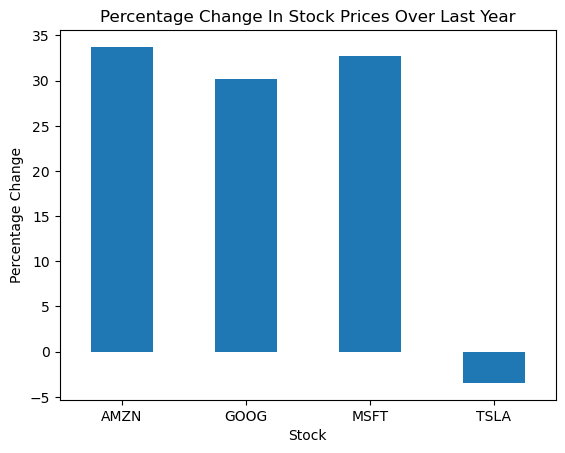

In [9]:
# Plot bar chart
price_changes.plot(kind='bar')
plt.title('Percentage Change In Stock Prices Over Last Year')
plt.xlabel('Stock')
plt.ylabel('Percentage Change')
plt.xticks(rotation=0)
plt.show()

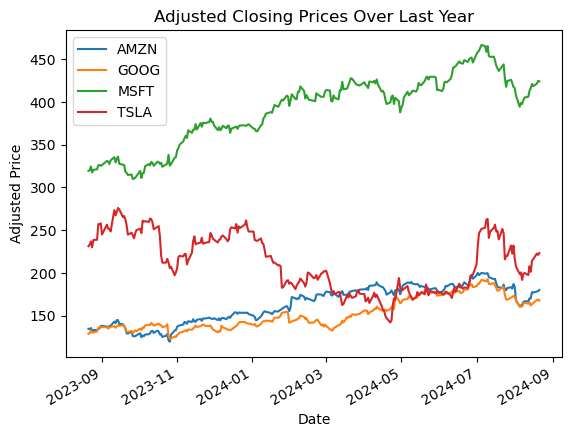

In [10]:
# Visualize data
stocks_data['Adj Close'].plot()
plt.title('Adjusted Closing Prices Over Last Year')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.legend(stocks_data['Adj Close'].columns)
plt.show()

#### *On average, what were the daily returns of the stocks?*

In [11]:
# Calculate daily returns
daily_returns = stocks_data['Adj Close'].pct_change()
print("Daily returns of the stocks:\n", daily_returns.head(10))

Daily returns of the stocks:
 Ticker          AMZN      GOOG      MSFT      TSLA
Date                                              
2023-08-21       NaN       NaN       NaN       NaN
2023-08-22 -0.003193  0.005895  0.001802  0.008258
2023-08-23  0.009460  0.027142  0.014079  0.015738
2023-08-24 -0.027155 -0.020944 -0.021498 -0.028793
2023-08-25  0.010771  0.002070  0.009407  0.037167
2023-08-28 -0.000900  0.008417  0.002229  0.000964
2023-08-29  0.013294  0.028075  0.014550  0.076878
2023-08-30  0.001186  0.010628  0.001157 -0.001089
2023-08-31  0.021766  0.003067 -0.003133  0.004593
2023-09-01  0.000797 -0.004004  0.002746 -0.050643


In [12]:
# Calculate average daily returns
avg_daily_returns = daily_returns.mean()
print("Average daily returns of the stocks:\n", avg_daily_returns)

Average daily returns of the stocks:
 Ticker
AMZN    0.001313
GOOG    0.001199
MSFT    0.001204
TSLA    0.000440
dtype: float64


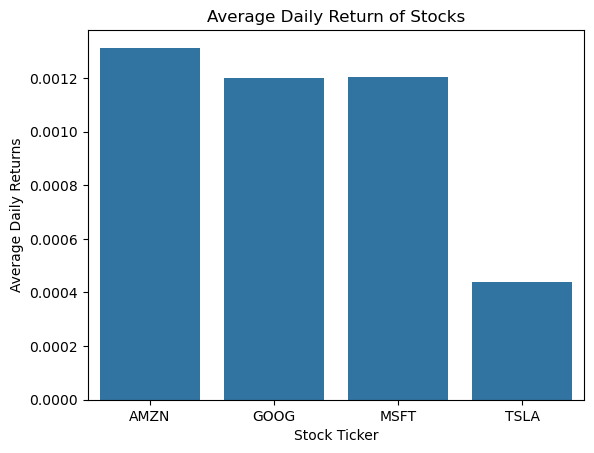

In [13]:
# Convert series to DataFrame
avg_daily_returns_df = avg_daily_returns.to_frame(name='Average Daily Returns')

# Reset indec to get stock tickers as column
avg_daily_returns_df.reset_index(inplace=True)

# Plot bar chart
sns.barplot(x='Ticker', y='Average Daily Returns', data=avg_daily_returns_df)
plt.title('Average Daily Return of Stocks')
plt.xlabel('Stock Ticker')
plt.ylabel('Average Daily Returns')
plt.show()

In [14]:
# Calculate daily returns
daily_returns = stocks_data['Adj Close'].pct_change()

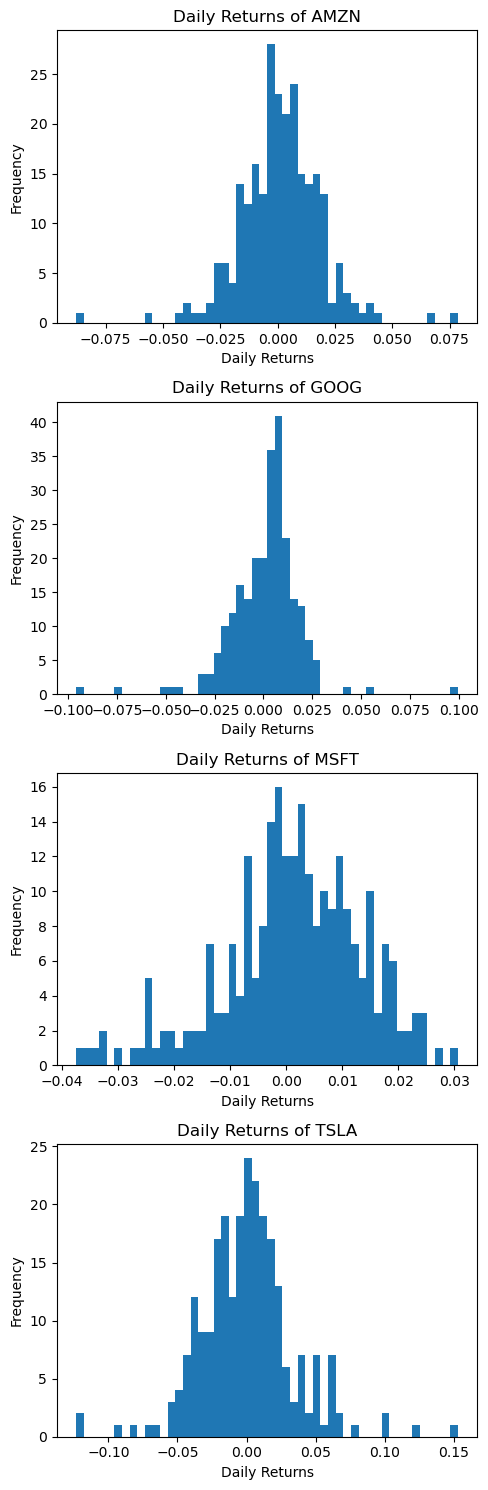

In [15]:
# Plot histograms for each stock's daily returns
num_stocks = len(daily_returns.columns)
fig, axs = plt.subplots(num_stocks, 1, figsize=(5, 15))
for i, stock in enumerate(daily_returns.columns):
    axs[i].hist(daily_returns[stock].dropna(), bins=50)
    axs[i].set_title(f'Daily Returns of {stock}')
    axs[i].set_xlabel('Daily Returns')
    axs[i].set_ylabel('Frequency')

# Display histogram plot
plt.tight_layout()
plt.show()

#### *What are the risks of investing in these particular stocks?*

In [16]:
# Calculate risks of investement using standard deviation
risk_measure = daily_returns.std()
print("Risk measure of daily returns:\n", risk_measure)

Risk measure of daily returns:
 Ticker
AMZN    0.017827
GOOG    0.017456
MSFT    0.012528
TSLA    0.034223
dtype: float64


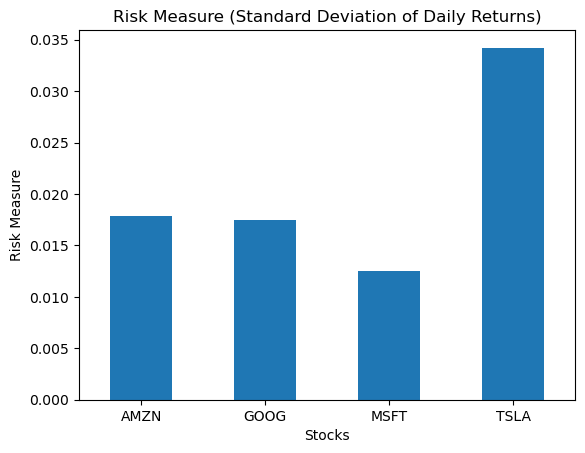

In [17]:
# Plot bar chart of the risk measure
risk_measure.plot(kind='bar')
plt.title('Risk Measure (Standard Deviation of Daily Returns)')
plt.xlabel('Stocks')
plt.ylabel('Risk Measure')
plt.xticks(rotation=0)
plt.show()

***

## **4. Stock Price Prediction Using LSTM**

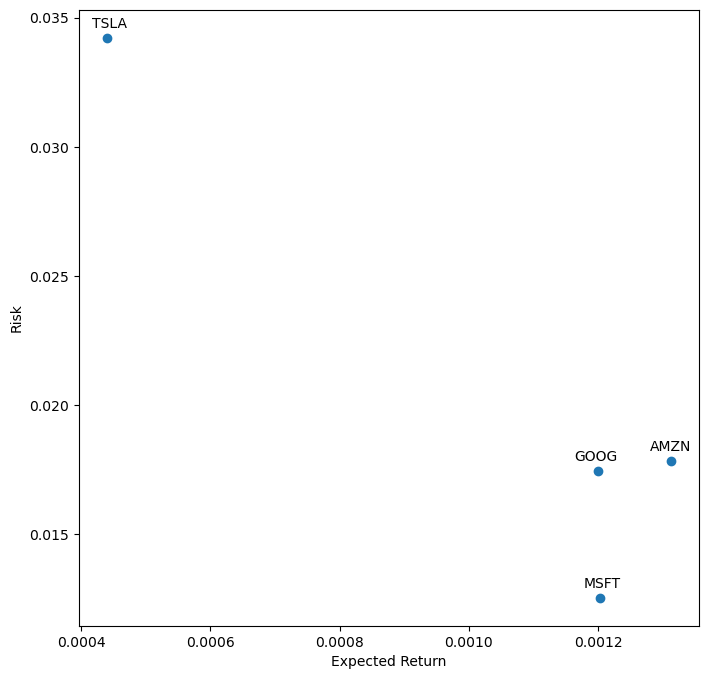

In [18]:
# Drop NA values to ensure accurate calculations
daily_returns = daily_returns.dropna()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(x=daily_returns.mean(), y=daily_returns.std())
plt.xlabel('Expected Return')
plt.ylabel('Risk')

# Annotate each point with its corresponding label
for label, x, y in zip(daily_returns.columns, daily_returns.mean(), daily_returns.std()):
    plt.annotate(label, xy=(x, y), xytext=(20, 10), textcoords='offset pixels', ha='right')
# Display scatter plot
plt.show()

#### *Can we predict the price of a particular stock?*

In [19]:
# Select preferred stock
data = stocks_data['Adj Close']['AMZN'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training and test sets
training_size = int(len(scaled_data) * 0.8)
testing_size = len(scaled_data) - training_size
training_data, testing_data = scaled_data[:training_size], scaled_data[training_size:]

# Convert array of values into dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        x = dataset[i:(i+time_step), 0]
        y = dataset[i+time_step, 0]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
time_step = 1
X_train, Y_train = create_dataset(training_data, time_step)
X_test, Y_test = create_dataset(testing_data, time_step)

# Reshape intput to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
# Custom loss function using TensorFlow
def custom_loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

## Convert arrays to TensorFlow datasets for optimized processing
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data = train_data.cache().shuffle(1000).batch(32).repeat()

test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_data = test_data.batch(32).repeat()

# Build LSTM Network using TensorFlow
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile LSTM model
model.compile(optimizer='adam', loss=custom_loss_function)

# TensorFlow callback for early stopping
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

# Train LSTM model
model_history = model.fit(train_data, batch_size=32, 
                          epochs=100, steps_per_epoch=100, 
                          validation_data=test_data, validation_steps=50, 
                          verbose=1, callbacks=[early_stopping_callback])

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1207 - val_loss: 0.0024
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━

***

## **5. Model Evaluation**

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train RMSE: 158.51612874410867, Test RMSE: 182.89480099477854


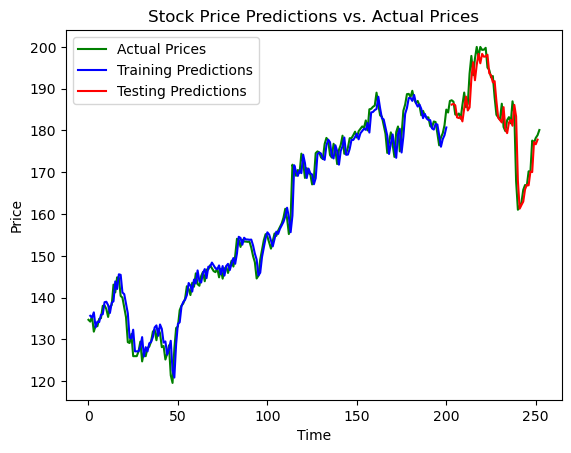

In [21]:
# Make predictions using trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# Inverse transform the actual prices
actual_prices = scaler.inverse_transform(scaled_data)

# Scale Y_test back to original price range
real_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Prepare NaN arrays for plotting predictions
predictions_plot = np.empty_like(scaled_data)
predictions_plot[:, :] = np.nan
test_predictions_plot = np.empty_like(scaled_data)
test_predictions_plot[:, :] = np.nan

# Insert predictions in appropriate place
predictions_plot[time_step:len(train_predictions) + time_step, :] = train_predictions
test_predictions_plot[len(train_predictions) + (time_step*2) + 1:len(scaled_data) - 1, :] = test_predictions

# Plotting
plt.plot(actual_prices, label='Actual Prices', color='green')
plt.plot(predictions_plot, label='Training Predictions', color='blue')
plt.plot(test_predictions_plot, label='Testing Predictions', color='red')
plt.title('Stock Price Predictions vs. Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
# Now, calculate performance metrics using real_test_prices and predictions
mse = mean_squared_error(real_prices, test_predictions)
mae = mean_absolute_error(real_prices, test_predictions)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
r2 = r2_score(real_prices, test_predictions)

# Print results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 14.7222549558275
Mean Absolute Error (MAE): 2.6655952297911334
Root Mean Squared Error (RMSE): 3.83695907664227
R² Score: 0.8723314188076373


An R² score of 0.87 is quite strong, indicating the model is explaining a large portion of the variance in the stock prices.

This suggests that our model captures the underlying trends and patterns in the data well.

However, the assessment should also consider context based on the stock's characteristics